In [55]:
import sys

from ompl import util as ou
from ompl import base as ob
from ompl import geometric as og

import math
import copy
import numpy as np
from numpy import linalg as LA
from urdf_parser_py.urdf import URDF
# from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics

f = open('/home/sai_kumar/iiwa7_setup/src/iiwa7_with_tool/urdf/iiwa7_with_tool.urdf', 'r')
robot = URDF.from_xml_string(f.read())  # parsed URDF
ee_kin = KDLKinematics(robot, "iiwa_link_0", "tcp")
ur_kin = KDLKinematics(robot, "iiwa_link_0", "iiwa_link_ee")
# p_trocar = np.array([[ 9.10937772e-01],[-1.31414659e-12],[ 6.54741958e-01]])
p_trocar = np.array([[-0.63218696], [0.0000982], [0.760526907]])
p_task = np.array([[-0.932186], [-0.151], [0.6605]])
p_task2 = np.array([[-0.932186], [-0.351], [0.6605]])

Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']/collision[1]
Unknown tag "self_collision_checking" in /robot[@name='iiwa7']/link[@name='iiwa_link_0']
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_1']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_2']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_3']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_4']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_5']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_6']/collision[1]
Unknown tag "material" in /robot[@name='iiwa7']/link[@name='iiwa_link_7']/collision[1]
Unknown tag "hardwareInterface" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']/actuator[@name='iiwa_motor_1']
Unknown tag "robotNamespace" in /robot[@name='iiwa7']/transmission[@name='iiwa_tran_1']
Unkno

In [56]:
def RCMImpl(q, p_ts):
        
        J_ext = np.zeros((6, 7), dtype=np.float64)
        
        
        
        p_i = ur_kin.forward(q)[:3, 3]
        p_t = ee_kin.forward(q)[:3, 3]

        AP = np.array(p_trocar - p_i)
        d = np.array(p_t - p_i)


        lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
        J_i = ur_kin.jacobian(q)[:3]
        J_t = ee_kin.jacobian(q)[:3]


        p_rcm = p_i + lam*(p_t - p_i)
        J_rcm = J_i + lam*(J_t - J_i)

        E = np.zeros([6, 1])
    
        E[:3,:] = p_ts- p_t
        E[3:, :] = p_trocar - p_rcm

        if np.linalg.norm(p_ts- p_t) < 0.0001 and np.linalg.norm(p_trocar - p_rcm)<0.005:
                return None

        J_ext[0] = (J_t)[0,:]
        J_ext[1] = (J_t)[1,:]
        J_ext[2] = (J_t)[2,:]
        J_ext[3] = (J_rcm)[0,:]
        J_ext[4] = (J_rcm)[1,:]
        J_ext[5] = (J_rcm)[2,:]

        J_pinv = np.linalg.pinv(J_ext)
        dq = np.matmul(J_pinv, E)
        dq = np.transpose(dq)[0]

        return dq

In [57]:
def inverse(p_task, q_near = np.array([0.1, 0.6941, 0.0000, 1.2947, 0.000, -1.3995, 0.000])):
    q1 = q_near

    reached = False
    while not reached:
        dq = RCMImpl(q1, p_task)
        if dq is None:
            reached = True
            break
        q1 = q1 + 0.1*dq
    return q1

In [58]:
class MyStateSpace(ob.RealVectorStateSpace):
    def __init__(self, ndof):
        self.ndof = ndof
        super(MyStateSpace, self).__init__(self.ndof)

        lower_limits = [-2.9321, -2.0594, -2.9321, -2.0594,-2.9321, -2.0594]
        upper_limits = [2.9321, 2.0594, 2.9321, 2.0594, 2.9321, 2.0594]

        joint_bounds = ob.RealVectorBounds(self.ndof)
        for i in range(self.ndof):
            joint_bounds.setLow(i, lower_limits[i])
            joint_bounds.setHigh(i, upper_limits[i])

        self.setBounds(joint_bounds)
        self.setup()

In [59]:
class MyStateValidityChecker(ob.StateValidityChecker):
    def __init__(self, space_information):
        super(MyStateValidityChecker, self).__init__(space_information)
        self.space_information = space_information

    def isValid(self, state):
        return self.space_information.satisfiesBounds(state) and self.clearance(state) < 0.005
    
    def clearance(self, state):
        # q = ur_kin.random_joint_angles()
        q = []
        for i in range(6):
            q.append(state[i])
        q.append(0.00)
        p_trocar = np.array([[-0.63218696], [0.0000982], [0.760526907]])
        p_i = ur_kin.forward(q)[:3, 3]
        p_t = ee_kin.forward(q)[:3, 3]

        AP = p_trocar - p_i
        
        d = p_t - p_i
        

        lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
        p_rcm = p_i + lam*(p_t - p_i)

        return np.linalg.norm(p_rcm - p_trocar)

In [60]:
class MyRRT:
    def __init__(self, ndof, step_size=0.05):
        self.ndof = ndof
        
        self.state_space = MyStateSpace(ndof)
        # self.control_space = MyControlSpace(self.state_space, ndof)
        self.simple_setup = og.SimpleSetup(self.state_space)
        si = self.simple_setup.getSpaceInformation()
        # si.setPropagationStepSize(step_size)
        # si.setMinMaxControlDuration(1, 1)
        # si.setDirectedControlSamplerAllocator(oc.DirectedControlSamplerAllocator(directedControlSamplerAllocator))

        # propagator = MyStatePropagator(self.simple_setup.getSpaceInformation(), ndof)
        # self.simple_setup.setStatePropagator(propagator)

        

        # self.planner = oc.KPIECE1(self.simple_setup.getSpaceInformation())
        # self.planner.setup()
        # ========= RRTConnect planner ============
        vc = MyStateValidityChecker(self.simple_setup.getSpaceInformation())
        self.simple_setup.setStateValidityChecker(vc)

        self.planner = og.RRTConnect(self.simple_setup.getSpaceInformation())
        p_goal = 0.05
        # self.planner.setGoalBias(p_goal)
        self.planner.setRange(0.05)


        self.simple_setup.setPlanner(self.planner)
        self.simple_setup.setup()
        
        


    def psolve(self, start, goal, timeout):
        self.simple_setup.setStartState(start)
        # mygoalregion = MyGoalRegion(self.simple_setup.getSpaceInformation(), goal, self.ndof)
        self.simple_setup.setGoalState(goal)

        
        
        # print(self.simple_setup)
        # print("Setup Done")
        

        if self.simple_setup.solve(timeout):
            print("Solved")
            if self.simple_setup.haveExactSolutionPath():
                print ("Exact Solution.")
                return self.simple_setup.getSolutionPath()
            elif self.simple_setup.haveSolutionPath():
                print ("Approximate Solution.")
                return self.simple_setup.getSolutionPath()
        else:
            print ("No Solution Found.")
            return None

In [67]:

if __name__ == '__main__':

    ndof = 6

    planner = MyRRT(ndof)

    start = ob.State(planner.state_space)
    goal = ob.State(planner.state_space)



    start_vector = inverse(p_task)
    goal_vector = inverse(p_task2, start_vector)
    for i in range(ndof):
        start[i] = start_vector[i]
        goal[i] = goal_vector[i]

    # ============== plan ===============
    print("REturned")
    result_path = planner.psolve(start, goal, 100)
    path = []
    joints = np.empty(ndof)
    for i in range(result_path.getStateCount()):
        
        for j in range(ndof):
            joints[j] = result_path.getStates()[i][j]
        path.append(copy.deepcopy(joints))

    print(path)

REturned
Info:    RRTConnect: Starting planning with 1 states already in datastructure
Solved
Exact Solution.
Info:    RRTConnect: Created 64 states (41 start + 23 goal)
Info:    Solution found in 0.813144 seconds
[array([ 0.96005061,  0.27385187, -1.08900846,  1.31654225,  0.57991396,
       -0.93643131]), array([ 0.99938531,  0.28324212, -1.11593267,  1.3062665 ,  0.5756041 ,
       -0.94037165]), array([ 1.02918628,  0.26000932, -1.14287318,  1.29819238,  0.55895066,
       -0.94232592]), array([ 1.06855773,  0.27298401, -1.16683674,  1.28752324,  0.55081701,
       -0.94755158]), array([ 1.08089624,  0.24990886, -1.17987327,  1.26729816,  0.5158291 ,
       -0.94406732]), array([ 1.11972029,  0.26444487, -1.2044423 ,  1.25769734,  0.51003332,
       -0.95127795]), array([ 1.13965347,  0.24016319, -1.21398767,  1.26342564,  0.47961573,
       -0.92973936]), array([ 1.15365592,  0.21883752, -1.22261966,  1.23844384,  0.44572807,
       -0.9312133 ]), array([ 1.1776803 ,  0.20970788, 

In [68]:
import  matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

[ 0.96005061  0.27385187 -1.08900846  1.31654225  0.57991396 -0.93643131]
[ 0.99938531  0.28324212 -1.11593267  1.3062665   0.5756041  -0.94037165]
[ 1.02918628  0.26000932 -1.14287318  1.29819238  0.55895066 -0.94232592]
[ 1.06855773  0.27298401 -1.16683674  1.28752324  0.55081701 -0.94755158]
[ 1.08089624  0.24990886 -1.17987327  1.26729816  0.5158291  -0.94406732]
[ 1.11972029  0.26444487 -1.2044423   1.25769734  0.51003332 -0.95127795]
[ 1.13965347  0.24016319 -1.21398767  1.26342564  0.47961573 -0.92973936]
[ 1.15365592  0.21883752 -1.22261966  1.23844384  0.44572807 -0.9312133 ]
[ 1.1776803   0.20970788 -1.23391443  1.24468365  0.41764481 -0.90147608]
[ 1.21348002  0.22478726 -1.26167904  1.2361275   0.42113088 -0.91308463]
[ 1.22689732  0.20761867 -1.25795714  1.22346573  0.379046   -0.9220236 ]
[ 1.26149131  0.2248075  -1.28527725  1.21549423  0.38536963 -0.93458855]
[ 1.29538257  0.24209046 -1.31332602  1.20671293  0.38930994 -0.94775333]
[ 1.32927383  0.25937342 -1.34137478  

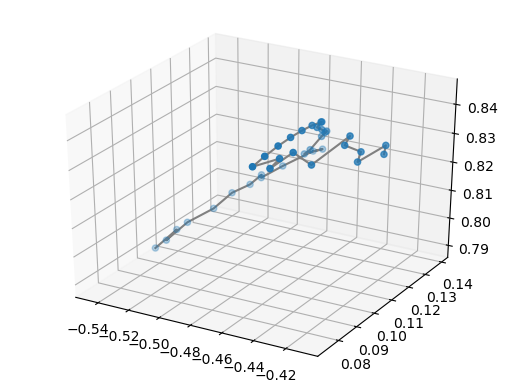

In [69]:
ee_list  = []
for i in path:
    print(i)
    q = [i[0],i[1],i[2],i[3],i[4],i[5],0.00]
    e = ur_kin.forward(q)[:3, 3]
    ee_list.append([e[0,0], e[1,0], e[2,0]])

print(ee_list)

fig = plt.figure()
ax = plt.axes(projection='3d')
x_data = []
y_data = []
z_data = []
for i in ee_list:
    x_data.append(i[0])
    y_data.append(i[1])
    z_data.append(i[2])
ax.plot3D(x_data,y_data,z_data, 'gray')
ax.scatter3D(x_data,y_data,z_data, 'red')

plt.show()

In [70]:
def constraintfunction(q = ur_kin.random_joint_angles()):
    
    out = np.zeros((3,1), dtype=np.float64)
    
    
    p_i = ur_kin.forward(q)[:3, 3]
    p_t = ee_kin.forward(q)[:3, 3]

    AP = p_trocar - p_i
    
    d = p_t - p_i
    

    # dist = LA.norm(np.cross(np.transpose(AP), np.transpose(d)))/LA.norm(d)
    lam = np.dot(np.transpose(AP), d)[0,0]/LA.norm(d)**2
    p_rcm = p_i + lam*(p_t - p_i)
    # print("P_rcm: ",p_rcm)

    out[0] = (p_rcm - p_trocar)[0,:]
    out[1] = (p_rcm - p_trocar)[1,:]
    out[2] = (p_rcm - p_trocar)[2,:]

    
    return out

[[3.861720609954489e-09, -6.079675242734971e-09, -2.3981998609201582e-09], [-0.0002889413665042584, -0.00198767213289202, 0.0040549992364339316], [0.0017548087614113195, -0.0014096683098359587, -0.0028921356659759034], [0.0016065260133553139, -0.0038762113854316567, 0.001238631016387437], [-0.0015796097251018493, 0.0024096420292774932, 0.0011237420612553173], [-0.001671262340309898, 0.00015232149135064427, 0.004357588602610041], [0.0006562782552006485, 0.0006864544373490694, -0.002493945943423448], [-0.001536986537540419, 0.001598581991657778, 0.002078032227359805], [-0.0019966565192491847, 0.003795984024873154, 0.0011228686666470145], [-0.002380527121163545, 0.0026915379752266914, 0.0030473085680085], [0.0005912187951769843, -0.0029550424191599135, 0.0014515691463573566], [0.0002944062539506076, -0.0035859144494925295, 0.0030050901344365055], [-0.0003843786999943033, -0.0026993531628778035, 0.0038667531664813293], [-0.000989012570002723, -0.0016446487740378398, 0.00425704346151301], [

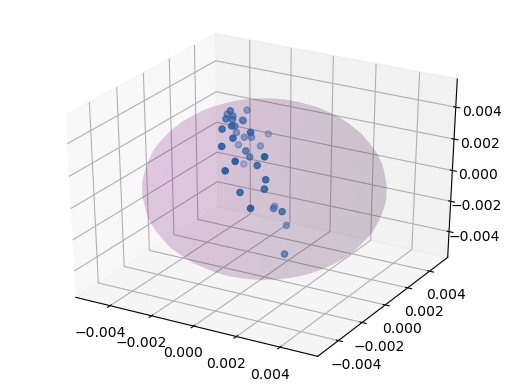

In [71]:
rcm_list  = []
for i in path:
    q = [i[0],i[1],i[2],i[3],i[4],i[5],0.00]
    e = constraintfunction(q)
    rcm_list.append([e[0,0], e[1,0], e[2,0]])

print(rcm_list)

fig = plt.figure()
ax = plt.axes(projection='3d')
x_data = []
y_data = []
z_data = []
for i in rcm_list:
    x_data.append(i[0])
    y_data.append(i[1])
    z_data.append(i[2])
# ax.plot3D(x_data,y_data,z_data, 'gray')
ax.scatter3D(x_data,y_data,z_data, 'red')

r = 0.005
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
ax.plot_surface(x, y, z, alpha = 0.1, color='purple')

plt.show()

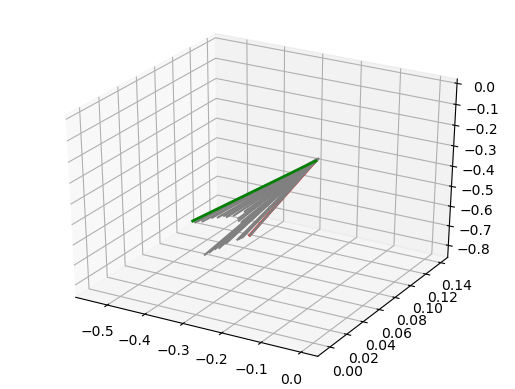

In [72]:
fig = plt.figure()
ax = plt.axes(projection='3d')
i = 0
x_data0 = [ee_list[i][0], rcm_list[i][0]]
y_data0 = [ee_list[i][1], rcm_list[i][1]]
z_data0 = [-ee_list[i][2], -rcm_list[i][2]]
ax.plot3D(x_data0,y_data0,z_data0, 'red', linewidth=2)
for i in range(len(ee_list)):
    x_data = [ee_list[i][0], rcm_list[i][0]]
    y_data = [ee_list[i][1], rcm_list[i][1]]
    z_data = [-ee_list[i][2], -rcm_list[i][2]]
    ax.plot3D(x_data,y_data,z_data, 'gray')
i = len(ee_list) - 1
x_data1 = [ee_list[i][0], rcm_list[i][0]]
y_data1 = [ee_list[i][1], rcm_list[i][1]]
z_data1 = [-ee_list[i][2], -rcm_list[i][2]]
ax.plot3D(x_data1,y_data1,z_data1, 'green',linewidth=2)

plt.show()